<a href="https://colab.research.google.com/github/rmiclark/SIADS-592-StreamingVid-Analytics/blob/main/rmiclark_nithyara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Environment Configuration

Install and load requisite packages

In [211]:
!pip install twitter
!pip install twython
!pip install pytrends --upgrade
! pip install nltk
! pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from google.colab import files
from google.colab import drive
import pandas as pd  
import numpy as np  
import io
import re     
import twitter
from twython import Twython 
import warnings
import time
import os
import random
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from pytrends.request import TrendReq
from pytrends import dailydata
import altair as alt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from scipy.stats import pearsonr
nltk.download('stopwords')
% matplotlib inline
pytrend = TrendReq()
nltk.download('vader_lexicon')
warnings.filterwarnings("ignore")

Requirement already up-to-date: pytrends in /usr/local/lib/python3.7/dist-packages (4.7.3)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Mount Google Drive containing data files

In [ ]:
# Auth code: 4/1AY0e-g6d5zOL9PZIAYudUuOrZR0Yw0xJet52GPyqHSWJAOoT5yjU4RQp5zQ

drive.mount('/content/drive')
# navigate to shared drive data folder
os.chdir('/content/drive/Shared drives/SIADS 591 Milestone - File Collab/data_files')

Mounted at /content/drive


# Data Wrangling & Pre-Processing

### Data Import & Pre-Process

CSV files containing shows and movies on popular streaming platforms (Netflix, Hulum, Disney+, Amazon Prime) and their associated attributes (release year, IMDB ratings, director(s), cast, genre, etc.)

**all_streaming_shows.csv**
<br>
source: https://www.kaggle.com/amritvirsinghx/web-series-ultimate-edition

**all_streaming_movies.csv**
<br>
source: https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset?select=IMDb+ratings.csv



In [ ]:
streamShows_df = pd.read_csv('all_streaming_shows.csv')
streamMovies_df = pd.read_csv('all_streaming_movies.csv')

Pre-Process Video Content Data

In [ ]:
# create df of video content (shows and movies) and release year
streamShowsColumns = {'Year Released':'Year','Series Title':'Title','Content Rating':'Age','IMDB Rating':'IMDb','Genre':'Genres'}
streamShows_df.rename(columns = streamShowsColumns, inplace=True)
videoContent_df = pd.concat([streamShows_df[['Title','Year','Age','IMDb','Genres']],streamMovies_df[['Title','Year','Age','IMDb','Genres']]])

# exclude records before 2016
videoContent_df = videoContent_df[videoContent_df['Year']>=2016]

# unique titles only for Twitter and Google Trends API calls
videoContent_df = videoContent_df.drop_duplicates(subset=['Title'])

# remove titles with < 2 substrings to improve liklihood of retrieving good API results
videoContent_df['title_length'] = list(videoContent_df['Title'].apply(lambda x: len(x.split())))
videoContent_df = videoContent_df[videoContent_df['title_length']>=2]

In [ ]:
videoContent_df.head(5)

Title  Year  ...                              Genres  title_length
3   Stranger Things  2016  ...                       Drama,Fantasy             2
4          The Boys  2019  ...           Action & Adventure,Comedy             2
20      Money Heist  2017  ...         Thriller,Action & Adventure             2
23        Cobra Kai  2018  ...            Action & Adventure,Drama             2
25  The Mandalorian  2019  ...  Action & Adventure,Science-Fiction             2

[5 rows x 6 columns]

In [ ]:
print('Unique shows and movies: {}'.format(len(videoContent_df)))

Unique shows and movies: 7895


### Twitter API

This section captures the code used to generate the twitter tweet data used for ML model build. The code took several days to run (work around rate limits); the output was stored as a CSV containing 11.9M tweets, 2.28 GB in size.

Load API credentials for Twitter developer account

In [ ]:
# APP_KEY = Hidden
# APP_SECRET = Hidden
# twitter = Twython(APP_KEY, APP_SECRET)

Run Twitter API, load output data into DF and save to CSV
 
 - run for each piece of content in video content DF
 - due to rate limiations, once reach rate limitation, save to CSV and resume from prior position
 - load CSV containing Twitter data from prior run
 
- challenge - twitter limits the amount of data you can extract per request and imposes a 15 min interval API call requirement (i.e. have to wait 15 mins before calling again).

In [ ]:
# function to create CSVs to hold each independent Twitter API run

def create_csvs(file_count,file_name,parentDirectory,leafDirectory):
    # specifify path to new directory / folder to store the CSV files in
    path = os.path.join(parentDirectory, leafDirectory) 
    # Create the directory
    os.makedirs(path)
    os.chdir(path)
    for n in range(1,file_count+1):
        csv = pd.DataFrame()
        csv.to_csv('{}{}.csv'.format(file_name,n))
    return print('CSVs created!')

In [ ]:
# function to call the Twitter API periodically and store the output in CSV, 
# to remain in compliance with Twitter rate limitations

def twitter_job(search_list, job_interval, path, attempts, tweets_to_be_fetched):
    # navigate to the path containing empty CSVs to store the output in
    os.chdir(path)
    
    # loop thru each of the CSVs to open and store the output in
    for file in range(0,len(os.listdir())):
        df = pd.read_csv(list(os.listdir())[file])
        
        # try statement to run twitter job until completion. upon completion, break the while loop and save CSV file
        # before looping to the next CSV and starting the next twitter run
        
        try:

            while True:
                
                # lists to store output from Twitter API call
                index_number = []
                title = []
                tweet_string = []
                tweet_ts = []
                tweet_rtcount = []
                tweet_sc = []
                tweets_fc = []

                # if we've already have result stored in CSV from prior run then pickup where we left off, else start a new, 
                # if we've completed all titles then terminate while loop (assert)

                if len(df) == 0:
                    index_range = range(int(0),int(len(search_list)))

                elif (len(df) > 0) & (df.index_number.max() < len(search_list)-1):
                    index_range = range(int(df.index_number.max()+1),int(len(search_list)))

                else:
                    assert False # stop while loop once all tweets have beeen compiled

                print("current run position: {}".format(search_list[index_range[0]]))
                
                # loop thru each content and extract tweets 
                for list_position in index_range:
                    
                    # try / except : if API call fails (rate limitation) then pause execution of cell block
                    # until job interval passes (func param) to try again
                    try:
                        # search term = title; exclude retweets from results
                        search_term = str("{} -filter:retweets".format(search_list[list_position]))
                        print(search_term)

                        # range in attempts is the number of twitter search attempts per tweet
                        for i in range(0,attempts):

                            if(len(index_number) > tweets_to_be_fetched):
                                break # maxed out number of tweets to be fetched for each title (tweets_to_be_fetched param)

                            # query Twitter
                            if(i == 0):
                                # query twitter for data
                                results = twitter.search(q=search_term,lang="en",count='1000')
                            else:
                                # after the first call we should have max_id from result of previous call - pass it in query
                                results = twitter.search(q=search_term,lang="en",include_entities='true',max_id=next_max_id,count='100')

                            # save the returned tweets (JSON object)
                            for result in results['statuses']:
                                index_number.append(list_position)
                                title.append(search_list[list_position])
                                tweet_string.append(result['text']) # write tweet string to list
                                tweet_ts.append(result['created_at']) # write tweet time_stamp to list
                                tweet_rtcount.append(result['retweet_count']) # whether a tweet was re-tweeted
                                tweet_sc.append(result['user']['statuses_count']) # number of tweets (including RTs) issued by the user to date
                                tweets_fc.append(result['user']['followers_count']) # number of followers the tweet owner has

                            # get the next max_id, pass this into next API call
                            try:
                                # Parse the data returned to get max_id to be passed in consequent call.
                                next_results_url_params = results['search_metadata']['next_results']
                                next_max_id = next_results_url_params.split('max_id=')[1].split('&')[0]
                            except:
                                # No more next pages
                                break
                            
                            #print("Number of records for this API run: {}".format(len(tweet_string)))

                    except:
                        break

                twitter_df_temp = pd.DataFrame([index_number, title, tweet_string, tweet_ts, tweet_rtcount, tweet_sc, tweets_fc]).T
                twitter_df_temp.columns = ['index_number','title','tweet_string','tweet_timestamp','tweet_retweet_count','user_tweet_count','user_followers']

                # if len of empty CSV dataframe is 0 (i.e. no results stored yet) then use the twitter_df
                # else concat results
                
                
                
                if len(df)==0:
                    df = twitter_df_temp

                else:
                    # concatenate the new results with the prior results stored in CSV file 
                    df = pd.concat([df, twitter_df_temp])
                
                print('{} runs complete, now sleeping until next batch...'.format(len(df)))
                df.to_csv(list(os.listdir())[file], index = False)
                time.sleep(job_interval)
            
        except:
            # overwrite stored CSV with new appended results
            df.to_csv(list(os.listdir())[file], index = False)

In [ ]:
def combine_csvs(path, master_name):
    os.chdir(path)
    parent_df = pd.DataFrame()
    for file in range(0,len(os.listdir())):
        df = pd.read_csv(list(os.listdir())[file])
        parent_df = pd.concat([df,parent_df])
    parent_df = parent_df.drop_duplicates()
    parent_df.to_csv('{}.csv'.format(mater_name))
    return print('CSV compilation complete!')

Text cleaning for Twitter API call (remove special chars)

In [ ]:
# remove special characters from title as these are not supported by APIs
videoContentTwitter_df = videoContent_df
title_clean = []
for title in list(videoContentTwitter_df['Title']):
    for x in title.split("\n"):
        title_clean.append(re.sub(r"[^a-zA-Z0-9]+", ' ', x))
videoContentTwitter_df['Title'] = title_clean

Call above functions and pass in required parameters

In [ ]:
runs = 10 # number of discrete TWITTER API runs (CSV file per run) to instatiate
parent_dir = os.getcwd() # specify path to create folder to hold CSV for each run
folder = 'twitter_run_20210502' # define folder name to hold output of Twitter runs

search_list = videoContentTwitter_df.Title.to_list()
refresh_interval = 60*15 # run every 15 minutes (interval is in seconds)
# subdir_path = ''
attempts = 10000 # the number of twitter search attempts per tweet (API call param)
tweets_to_be_fetched = 100000 # max number of tweets to return per tweet search (API call param)

# execute twitter_job function to invoke API call - do not execute due to execution time 

#twitter_job(search_list,refresh_interval,subdir_path,attempts, tweets_to_be_fetched)

**output from Twitter API call**

In [ ]:
# Read data in from the Twitter API output
tweet_df = pd.read_csv('tweetDataFinal.csv')

In [ ]:
# Function to search tweet string for a direct match with the movie (API call returns fuzzy matches which we want to exclude)
def str_match(tweet,title):
    return str(tweet).lower().find(str(title).lower())

# Remove tweets that are not a direct sub string match with the video content title
tweet_df['movie_tweet_str_match'] = tweet_df.apply(lambda x: str_match(x['tweet_string'],x['title']), axis=1)
tweet_df = tweet_df[tweet_df['movie_tweet_str_match']>0]

In [ ]:
# Remove content containing < 500 tweets, consider 500 as the minimum threshold
tweet_df['tweet_count'] = tweet_df.groupby('title').tweet_retweet_count.transform(np.size)
tweet_df = tweet_df[tweet_df.tweet_count>=200]

In [ ]:
# func to compute z-score for each continuous variable (user_tweet_count, tweet_retweet_count and user_followers)
# relative to other values for the same title, 
# use this to weight sentiment scores (i.e. some tweets more influential than others)

fields = ['user_tweet_count','tweet_retweet_count','user_followers']
for field in fields:
    sd = tweet_df.groupby('title')['{}'.format(field)].transform(np.std)
    mean = tweet_df.groupby('title')['{}'.format(field)].transform(np.mean)
    observed = tweet_df['{}'.format(field)]
    # compute and return z-score per tweet
    zscore = (observed - mean) / sd
    
    # global z-score across entire dataset
    mean_g = np.mean(tweet_df['{}'.format(field)])
    std_g = np.mean(tweet_df['{}'.format(field)])
    observed_g = tweet_df[['{}'.format(field)]]
    # compute z-score for every record in the dataset
    zscore_g = (observed_g - mean_g) / std_g
    
    tweet_df['{}_zscore_local'.format(field)] = zscore
    tweet_df['{}_zscore_global'.format(field)] = zscore_g

### Twitter Sentiment Classifier

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. It is fully open-sourced under the [MIT License] (we sincerely appreciate all attributions and readily accept most contributions, but please don’t hold us liable).

Source: https://pypi.org/project/vaderSentiment/

In [ ]:
#Initialize SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

#Find positive, neutral, negative, and compound sentiment scores for each tweet
tweet_df['sentiment'] = tweet_df['tweet_string'].apply(lambda x: list(sia.polarity_scores(str(x)).values()))
tweet_df['positive_sentiment'] = tweet_df['sentiment'].apply(lambda x: x[2])
tweet_df['neutral_sentiment'] = tweet_df['sentiment'].apply(lambda x: x[1])
tweet_df['negative_sentiment'] = tweet_df['sentiment'].apply(lambda x: x[0])
tweet_df['compound_sentiment'] = tweet_df['sentiment'].apply(lambda x: x[3])

#Dummy variables for positive and negative sentiment (if compound is greater than 0, the tweet is overall positive)
tweet_df['pos_binary'] = tweet_df['compound_sentiment'].apply(lambda x: 1 if x >=0 else 0)
tweet_df['neg_binary'] = tweet_df['compound_sentiment'].apply(lambda x: 0 if x >=0 else 1)

Adjust the individual sentiment scores as a func of the z-score for each individual tweet, based on user's followers (for the same title "local", and entire dataset "global) as well as the retweet count "tweet_retweet" count.

Higher z-score's for user followers and tweet_retweet count suggests these are more influential tweets therefore their sentiment scores receive more weigtage.

In [ ]:
# compute % of positive (binary) tweets for each title, as a % of overall title tweets
tweet_df['sentiment_absolute_sum'] = tweet_df.groupby('title')['pos_binary'].transform(np.sum)
tweet_df['sentiment_absolute_pct_positive'] = tweet_df['sentiment_absolute_sum']/tweet_df['tweet_count']
# compute z-score adjusted sentiment scores
tweet_df['positive_sentiment_userFollowers_adj'] = tweet_df['positive_sentiment'] * tweet_df['user_followers_zscore_local']
tweet_df['negative_sentiment_userFollowers_adj'] = tweet_df['negative_sentiment'] * tweet_df['user_followers_zscore_local']
tweet_df['positive_sentiment_userFollowers_adj_global'] = tweet_df['positive_sentiment'] * tweet_df['user_followers_zscore_global']
tweet_df['negative_sentiment_userFollowers_adj_global'] = tweet_df['negative_sentiment'] * tweet_df['user_followers_zscore_local']
tweet_df['positive_sentiment_tweetRetweet_adj'] = tweet_df['positive_sentiment'] * tweet_df['tweet_retweet_count_zscore_local']
tweet_df['negative_sentiment_tweetRetweet_adj'] = tweet_df['negative_sentiment'] * tweet_df['tweet_retweet_count_zscore_local']
tweet_df['positive_sentiment_tweetRetweet_adj_global'] = tweet_df['positive_sentiment'] * tweet_df['tweet_retweet_count_zscore_global']
tweet_df['negative_sentiment_tweetRetweet_adj_global'] = tweet_df['negative_sentiment'] * tweet_df['tweet_retweet_count_zscore_global']


### Twitter ML Model Quant Var Construction

In [ ]:
# count substring length of tweet string
tweet_df['tweet_length'] = tweet_df['tweet_string'].apply(lambda x: len(str(x)))

Aggregation of Tweet continuous vars for each Title to be used in the ML model

In [ ]:
# list of the quantitative tweet fields to aggregate per video content
agg_fields = ['tweet_retweet_count','user_tweet_count','user_followers','positive_sentiment',\
              'neutral_sentiment','negative_sentiment','pos_binary','neg_binary','positive_sentiment_userFollowers_adj',\
             'negative_sentiment_userFollowers_adj','positive_sentiment_userFollowers_adj_global',\
              'negative_sentiment_userFollowers_adj_global','positive_sentiment_tweetRetweet_adj',\
              'negative_sentiment_tweetRetweet_adj','negative_sentiment_tweetRetweet_adj_global','positive_sentiment_tweetRetweet_adj_global','tweet_length']

# field name and metric array to be passed into DF for final tweet output DF agg
agg_output = {}

for field in agg_fields:
    min_val = tweet_df.groupby('title')['{}'.format(field)].agg(np.min).to_list()
    max_val = tweet_df.groupby('title')['{}'.format(field)].agg(np.max).to_list()
    stdev = tweet_df.groupby('title')['{}'.format(field)].agg(np.std).to_list()
    mean = tweet_df.groupby('title')['{}'.format(field)].agg(np.average).to_list()
    median = tweet_df.groupby('title')['{}'.format(field)].agg(np.median).to_list()
    index = tweet_df.groupby('title')['user_followers'].agg(np.min).index.to_list()

    agg_output['title'] = index
    agg_output['{}_min'.format(field)] = min_val
    agg_output['{}_max'.format(field)] = max_val
    agg_output['{}_stdev'.format(field)] = stdev
    agg_output['{}_mean'.format(field)] = mean
    agg_output['{}_median'.format(field)] = median

# create a df of tweet quantative data, aggregated on each title
tweet_aggQuant_df = pd.DataFrame.from_dict(agg_output)

# add in tweet_count and absolute % positive (binary) which have already been aggregated
prev_agg = tweet_df.drop_duplicates('title')[['title','tweet_count','sentiment_absolute_pct_positive']]
tweet_aggQuant_df = pd.merge(tweet_aggQuant_df,prev_agg,how='left',right_on='title', left_on='title')

In [ ]:
# df containing twitter model vars
tweet_aggQuant_df.head()

title  ...  sentiment_absolute_pct_positive
0      100 Meters  ...                         0.844037
1  13 Reasons Why  ...                         0.785467
2            2 22  ...                         0.976923
3      20 Minutes  ...                         0.761257
4        20 Weeks  ...                         0.836570

[5 rows x 88 columns]

### Google Trends API

**pytrends get_daily_data method**

Given a word, fetches daily search volume data from Google Trends and returns results in a pandas DataFrame.
    
Details: Due to the way Google Trends scales and returns data, special care needs to be taken to make the daily data comparable over different months. To do that, we download daily data on a month by month basis, and also monthly data. The monthly data is downloaded in one go, so that the monthly values are comparable amongst themselves and can be used to scale the daily data. The daily data is scaled by multiplying the daily value by the monthly search volume divided by 100.

For a more detailed explanation see http://bit.ly/trendsscaling

Source: https://github.com/GeneralMills/pytrends/blob/master/pytrends/dailydata.py



In [ ]:
# cell magic to suppress the print output from the Google Trends API
%%capture 

def GoogleTrendsJob(videoContent_df):
  
  # read in Google Trends from prior run, else create empty DF to store Google Trends output
  try:
    gTrends_df = pd.read_csv('googleTrendsData.csv')
    start_position = gTrends_df.Title.nunique()+1
  except:
    gTrends_df = pd.DataFrame()  
    start_position = 0

  # loop thru each title and retrieve Google Trend data; append data to gTrends_df

  while start_position < len(videoContent_df):

      for record in range(start_position,len(videoContent_df)):
          term = videoContent_df.iloc[record].Title
          year = int(videoContent_df.iloc[record].Year)

          # call pytrends get_daily_data_method and pass in search term, and release year
          
          try:
          
              df = dailydata.get_daily_data(term, year, 1, year+1, 3, geo = 'US')
              df['Title'] = term
              df.columns = df.columns.str.replace('{}'.format(term),'search_trend')

              # store output in gTrends_df and write to CSV within loop in case execution fails or is stopped
              print('completed record number {}'.format(record))
              
              gTrends_df = pd.concat([gTrends_df,df])
              gTrends_df.to_csv('googleTrendsData.csv',index=False)
              
          except:
              # this occurs if Google returns 
              # "The request failed: Google returned a response with code 429"
              # pause execution for 15 minutes

              print('taking a nap, left off at position {}'.format(record))
              time.sleep(60*15) # run every 15 minutes (interval is in seconds)

In [ ]:
# call to Google Trends API passing in the videoContent_df containing search terms - do not execute due to execution time 
# GoogleTrendsJob(videoContent_df)
GoogleTrends = pd.read_csv('gTrends_data.csv')

### Dataset joining

Twitter model vars joining

In [ ]:
# Twitter data was run on a "clean" Title string, need to revert back to original title
# define original title (pre-clean) as "twitter_clean_title" as the join field
videoContent_df['twitter_clean_title'] = videoContentTwitter_df['Title']

# rename tweet_df "title" column to "twitter_clean_title" for joining / merging
tweet_df.columns = tweet_df.columns.str.replace('title','twitter_clean_title')
videoContent_df.columns = videoContent_df.columns.str.replace('Title','title')
# join tweet vars with video content vars
model_vars = tweet_aggQuant_df.merge(videoContent_df,how='left', left_on='title', right_on='title')
# drop videos with null IMDB ratings
model_vars = model_vars.dropna(subset=['IMDb'])

Google Trends model vars joining

In [ ]:
GoogleTrends.columns = GoogleTrends.columns.str.replace('Title','title')
GoogleTrends['search_trend_unscaled_sum'] = GoogleTrends[['title','search_trend_unscaled']].groupby('title')['search_trend_unscaled'].transform(np.sum)
GoogleTrends['search_trend_unscaled_mean'] = GoogleTrends[['title','search_trend_unscaled']].groupby('title')['search_trend_unscaled'].transform(np.mean)
GoogleTrends = GoogleTrends[['title','search_trend_unscaled_sum','search_trend_unscaled_mean']].drop_duplicates()

model_vars = model_vars.merge(GoogleTrends, how='left',left_on='title',right_on='title')
model_vars = model_vars.dropna(subset=['search_trend_unscaled_sum'])

In [ ]:
model_vars = model_vars.dropna(subset=['search_trend_unscaled_sum'])

# Data Analysis

In [ ]:
model_vars.head(3)

title  ...  search_trend_unscaled_mean
0      100 Meters  ...                   45.442982
1  13 Reasons Why  ...                   50.918681
2        20 Weeks  ...                   67.246154

[3 rows x 96 columns]

### Quant Vars Relationship

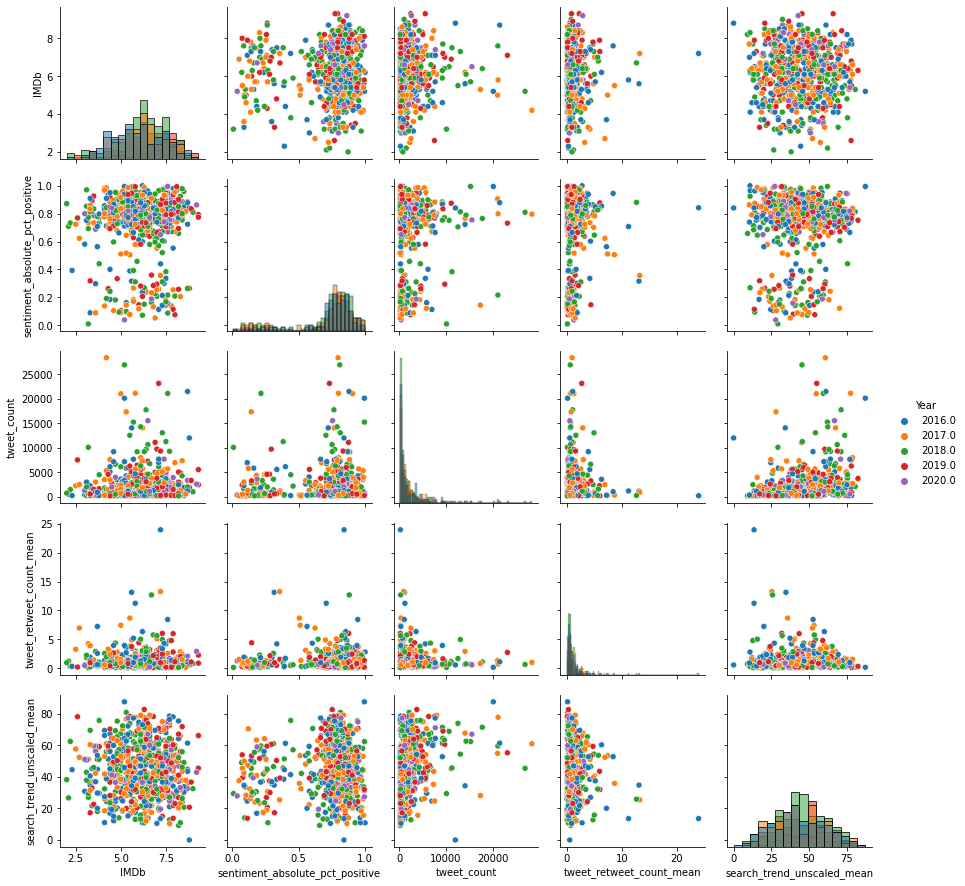

In [315]:
model_vars.Year = model_vars.Year.astype(str)
splom_df = model_vars[['IMDb','sentiment_absolute_pct_positive','tweet_count','tweet_retweet_count_mean','search_trend_unscaled_mean','Year']]
splom_df = splom_df.dropna()

sns.pairplot(splom_df, hue="Year", diag_kind='hist')

### Distributions 
(IMDB, Sentiment, Search Trends)

In [302]:
stdDevs = 1.5

# add upper and lower bounds to df for histogram visualization, based on above std devs param

fields = ['IMDb','sentiment_absolute_pct_positive','search_trend_unscaled_mean']
for field in fields:
  model_vars['{}_lower'.format(field)] = model_vars['{}'.format(field)] - (np.std(model_vars['{}'.format(field)]) * stdDevs)
  model_vars['{}_upper'.format(field)] = model_vars['{}'.format(field)] + (np.std(model_vars['{}'.format(field)]) * stdDevs)

base_chart = alt.Chart(model_vars)
#distribution of IMDb ratings with std deviations per above variable
imdb_bar = base_chart.mark_bar(color='#bca0dc').encode(alt.X("IMDb:Q", bin=True), y='count()')
agg1_imdb = base_chart.mark_rule(color='black').encode(x=alt.X('mean(IMDb_lower):Q',title='IMDB Ratings (+/- {} Standard Deviations)'.format(stdDevs)))
agg2_imdb = base_chart.mark_rule(color='black').encode(x=alt.X('mean(IMDb_upper):Q',title='IMDB Ratings (+/- {} Standard Deviations)'.format(stdDevs)))
imdb_histogram = imdb_bar + agg1_imdb + agg2_imdb
imdb_histogram = imdb_histogram.properties(width=600,height=560)

# distribution of sentiment scores with std deviations per above variable
sentiment_bar = base_chart.mark_bar(color='#bca0dc').encode(alt.X("sentiment_absolute_pct_positive:Q", bin=True), y='count()').interactive()
agg1_sentiment = base_chart.mark_rule(color='black').encode(x=alt.X('mean(sentiment_absolute_pct_positive_lower):Q',title='Twitter Sentiment Score (+/- {} Standard Deviations)'.format(stdDevs)))
agg2_sentiment = base_chart.mark_rule(color='black').encode(x=alt.X('mean(sentiment_absolute_pct_positive_upper):Q',title='Twitter Sentiment Score (+/- {} Standard Deviations)'.format(stdDevs)))
sentiment_histogram = sentiment_bar + agg1_sentiment + agg2_sentiment
sentiment_histogram = sentiment_histogram.properties(width=450,height=250)

# distribution of google trends with std deviations per above variable
gTrends_bar = base_chart.mark_bar(color='#bca0dc').encode(alt.X("search_trend_unscaled_mean:Q", bin=True), y='count()').interactive()
agg1_gTrends = base_chart.mark_rule(color='black').encode(x=alt.X('mean(search_trend_unscaled_mean_lower):Q',title="Google Searches '000 (+/- {} Standard Deviations)".format(stdDevs)))
agg2_gTrends = base_chart.mark_rule(color='black').encode(x=alt.X('mean(search_trend_unscaled_mean_upper):Q',title="Google Searches '000 (+/- {} Standard Deviations)".format(stdDevs)))
gTrends_histogram = gTrends_bar + agg1_gTrends + agg2_gTrends
gTrends_histogram = gTrends_histogram.properties(width=450,height=250)

sent_trend_metrics = alt.vconcat(sentiment_histogram,gTrends_histogram)
alt.hconcat(imdb_histogram,sent_trend_metrics)

alt.HConcatChart(...)

### Word Cloud

Define a function to create a cleaned string of individual tweets for each title in the dataframe 

In [257]:
# function for creating word cloud string from each individual tweet per title
def wc_string_clean(df):
  corpus = ''
  excl = ['http','@','txt_','txt','https','co','stranger things','sex','crown','ever','little','perfect','day']
  stop_words_nltk = [str(x).lower() for x in list(set(stopwords.words('english')))] 
  stop_words = stop_words_nltk + [x.lower() for x in list(df.twitter_clean_title.unique())]

  # loop thru each title in the tweet dataframe, create list of unqique words per title, convert list into string
  for title in list(df.twitter_clean_title.unique()):
    
    titleCorp_clean = []
    # generate a list of the tweet strings for each title and lowercase all substrings
    titleCorpus_raw = [str(x).lower() for x in df[df['twitter_clean_title']==title].tweet_string.to_list()]
    titleCorpus_raw = [w for w in titleCorpus_raw if not w in stop_words] 
    
    # remove exclusion words / characters from tweet substrings that are uninformative
    for text in titleCorpus_raw:
      clean = True
      for excl_item in excl:
        if text.find(excl_item) != -1:
              clean = False
              break
      if clean:
          titleCorp_clean.append(text)
        
    corpus = corpus + ''.join(set(titleCorp_clean))

  return corpus

Partition tweet dataframe based on IMDB ratings, sentiment scores and Google Trends searches into 6 homogenous dataframes representing records above / below 1.5 STDs from the mean for each of the 3 aforementioned metrics

In [249]:
# generate word cloud dataframe consisting of all tweet data for each title
wc_df = tweet_df[tweet_df.twitter_clean_title.isin(model_vars.twitter_clean_title.to_list())].merge(videoContent_df[['twitter_clean_title','IMDb']])
wc_df['title'] = wc_df['twitter_clean_title']
wc_df = wc_df.merge(GoogleTrends[['title','search_trend_unscaled_mean']], how='left',left_on='title',right_on='title')

# bifurcate titles into those with "high" IMDB ratings (>7.5) and "low" ratings (<4.9) 
imdb_pos_wc_df = wc_df[wc_df['IMDb']>8.2]
imdb_neg_wc_df = wc_df[wc_df['IMDb']<4.1]
# bifurcate titles into those with "high" sentiment scores (>95%) and "low" scores (<52%) 
sentiment_pos_wc_df = wc_df[wc_df['sentiment_absolute_pct_positive']>0.95]
sentiment_neg_wc_df = wc_df[wc_df['sentiment_absolute_pct_positive']<0.41]
# bifurcate titles into those with "high" search trends (>61K) and "low" trends (<29K) 
searchtrend_pos_wc_df = wc_df[wc_df['search_trend_unscaled_mean']>69]
searchtrend_neg_wc_df = wc_df[wc_df['search_trend_unscaled_mean']<20]

Pass each of the partitioned tweet dataframe's into the word cloud function to generate individual word clouds for each dataframe 

In [258]:
# generate wordcloud images by passing each dataframe into the wc_string_clean func
imdb_pos_wcloud = WordCloud(background_color="white").generate(wc_string_clean(imdb_pos_wc_df))
imdb_neg_wcloud = WordCloud(background_color="white").generate(wc_string_clean(imdb_neg_wc_df))
sentiment_pos_wcloud = WordCloud(background_color="white").generate(wc_string_clean(sentiment_pos_wc_df))
sentiment_neg_wcloud = WordCloud(background_color="white").generate(wc_string_clean(sentiment_neg_wc_df))
searchtrend_pos_wcloud = WordCloud(background_color="white").generate(wc_string_clean(searchtrend_pos_wc_df))
searchtrend_neg_wcloud = WordCloud(background_color="white").generate(wc_string_clean(searchtrend_neg_wc_df))

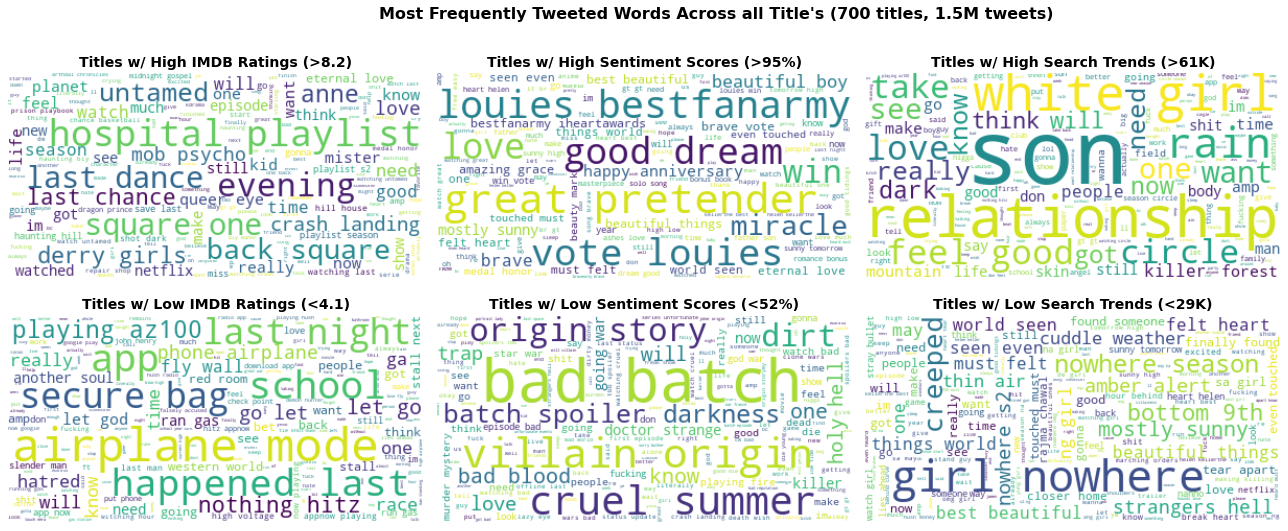

In [353]:
wcloud_objs = [imdb_pos_wcloud,sentiment_pos_wcloud,searchtrend_pos_wcloud,imdb_neg_wcloud,sentiment_neg_wcloud,searchtrend_neg_wcloud]
wcloud_titles = ['Titles w/ High IMDB Ratings (>8.2)','Titles w/ High Sentiment Scores (>95%)','Titles w/ High Search Trends (>61K)','Titles w/ Low IMDB Ratings (<4.1)','Titles w/ Low Sentiment Scores (<52%)','Titles w/ Low Search Trends (<29K)']

# set up figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 8))
fig.suptitle("Most Frequently Tweeted Words Across all Title's (700 titles, 1.5M tweets)", size=16, fontweight="bold")

# loop thru subplots and populate each with word cloud chart object and title from above lists
for i, ax in enumerate(axs.flatten()):
    ax.imshow(wcloud_objs[i], interpolation='bilinear')
    ax.set_title(wcloud_titles[i], size=14, fontweight="bold")
    ax.axis("off")

# adjust spacing for subplots
fig.tight_layout(rect=[0, 0.03, .9, 0.92])
plt.show()

In [299]:
wc_df['wc_label'] = pd.np.where(wc_df.tweet_string.str.contains("bad"),"bad",
                   pd.np.where(wc_df.tweet_string.str.contains("batch"), "batch","-"))

wc_df[wc_df['wc_label']!='-']

In [ ]:
# create class labels for tweets if tweet string contains substring "airplane","hospital","playlist"
wc_df['tweet_string'] = [str(x).lower() for x in wc_df.tweet_string.to_list()]
wc_df['wc_label'] = pd.np.where(wc_df.tweet_string.str.contains("airplane"),"airplane",
                   pd.np.where(wc_df.tweet_string.str.contains("hospital"), "hospital",
                   pd.np.where(wc_df.tweet_string.str.contains("playlist"), "playlist","-")))